# Tools Setup 

In [ ]:
!pip install keras-tuner
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import RandomSearch
from sklearn.mixture import GaussianMixture

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# Importing the Keras libraries and packages
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=9e0a9a1aa2af1db576d8ed7e335fa48dc7b847c8170e70276e1b1151c4d7b36a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=9ebd57169cf53374b1958c914a094a148adb180c20de50e10c978844ff8015b0
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# Data import and Exploration of the features and the targets
and visualization to have a first impression of how to work on them to extract the needed columns, and if and where are the missing values

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


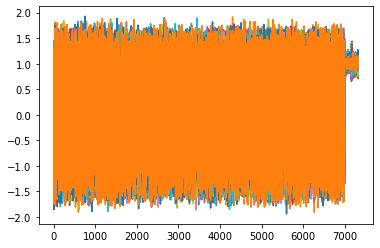

In [ ]:
plt.show(plt.plot(train))

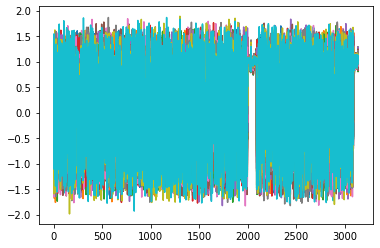

In [ ]:
plt.show(plt.plot(test))

Both the training and the test set have data points (plotted on the x axis) that span different ranges.
We can better visualize it with a box plot: Data points with index greater than 7000 have a different mean - a Higher one - and a lower variance.

The same happens in the test set

So next thing we do is creating a function to extract these values to separate the data in two dataset. The idea was to train different models for the two clusters of data points.

A way to obtain this cluster would be to project in a 2D space the time series Mean/variance, then use a clustering algorithm, but since the decision boundary is pretty easy to determinate, we don't need to use k-means or gaussian mixture.

We just plot mean and variance in a 2D space 

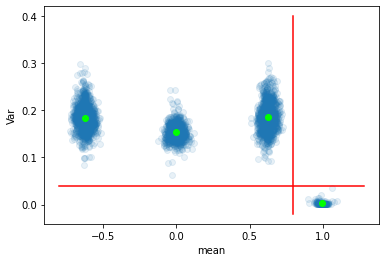

In [ ]:
def scatter_mean_variance(train):
  if 'y' in train.columns:
    train = train.drop(columns=['y'])
  n = train.shape[0]
  mu_sigma = np.zeros((n,2))
  score = np.zeros(n)
  for i in range(n):
    mean = np.mean(train.iloc[i])
    var = np.var(train.iloc[i])
    mu_sigma[i][0] = mean
    mu_sigma[i][1] = var
    score[i] = ( mean / var )**2

  plt.scatter(mu_sigma[:,0],mu_sigma[:,1],alpha=0.1)
  a = GaussianMixture(n_components=4, random_state=0).fit(mu_sigma).means_
  plt.scatter(a[:,0], a[:,1], c = 'lime')
  plt.plot([0.8,0.8],[-0.02,0.40], color = 'r')
  plt.plot([-0.8,1.28],[0.04,0.04], color = 'r')
  plt.xlabel('mean')
  plt.ylabel('Var')

  return mu_sigma

a = scatter_mean_variance(test)

the input 'a' for the gaussian micxture is returned by the function scatter mean variance, it is a 2D array of mean and varaince of each series

In [ ]:
gm = GaussianMixture(n_components=4, random_state=0).fit(a)
means = gm.means_

It is evident that there are 4 probability distribution generating the data, Gaussian Mixture Model could provide us an estimate of the parameter of these distributions. We have tries to implement it but it lead to poor prediction results, against our - probably naive - expecatations.

So we go for a manual clustering

# Indicator Functions

This Functions work as Indicator Functions for the two clusters that we have identified, the cutoff (decision boundary is mean > 0.8)

In [ ]:
def Indicator_1(df):
    df1 = df.copy()
    df_means = df.mean(axis = 1)
    for i in range(len(df_means)):
        if df_means[i] < 0.8:
            df1 = df1.drop([i])
    return df1

def Indicator_0(df):
    df1 = df.copy()
    df_means = df1.mean(axis = 1)
    for i in range(len(df_means)):
        if df_means[i] > 0.8:
            df1 = df1.drop([i])
    return df1

# SVR



## SVR training data

In [ ]:
train1 = Indicator_1(train)
targets1 = train1['y']
features1 = train1.drop(columns=['w','y'])

X_train, X_test, y_train, y_test = train_test_split(
    features1, targets1, test_size=0.25, random_state=1)

## SVR Fit

In [ ]:
reg = svm.SVR().fit(X_train, y_train)

ypredtrain = (reg.predict(X_train))
ypredtest = (reg.predict(X_test))

print("Test: ", (mean_squared_error(y_test,ypredtest)))
print("Train: ", (mean_squared_error(y_train,ypredtrain)))

Test:  0.001581064127144317
Train:  0.0014629836502230607


## SVR Tuning Parameters

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = RandomizedSearchCV(svm.SVR(kernel='rbf'), 
    {'C': [0.5,1,5,10,15,20],
    'epsilon': [1e-4, 1e-3, 1e-2, 0.1, 0.15, 0.3, 0.45, 0.75, ],
    'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9]}, 
    cv=5, 
    return_train_score=False,
    n_iter=50, 
    scoring=scorer)

clf.fit(features1, targets1)
best_10_i = clf.cv_results_['rank_test_score'] < 10      # print out the results of the randomized search
np.array(clf.cv_results_['params'])[best_10_i]           # these are the best 10

array([{'gamma': 0.9, 'epsilon': 0.001, 'C': 0.5},
       {'gamma': 0.6, 'epsilon': 0.0001, 'C': 0.5},
       {'gamma': 0.5, 'epsilon': 0.0001, 'C': 5},
       {'gamma': 0.6, 'epsilon': 0.0001, 'C': 1},
       {'gamma': 0.01, 'epsilon': 0.001, 'C': 20},
       {'gamma': 0.1, 'epsilon': 0.01, 'C': 5},
       {'gamma': 0.2, 'epsilon': 0.001, 'C': 20},
       {'gamma': 0.1, 'epsilon': 0.001, 'C': 10},
       {'gamma': 0.1, 'epsilon': 0.0001, 'C': 20}], dtype=object)

In [ ]:
clf = GridSearchCV(svm.SVR(kernel='rbf'), {
    'C': [0.5,1,5,10,15,20],
    'epsilon': [1e-4, 1e-3, 1e-2],
    'gamma': [0.1, 0.2, 0.5, 0.6]
}, cv=5, return_train_score=False, scoring=scorer)

clf.fit(features1, targets1)
best = clf.cv_results_['rank_test_score'] == 1
np.array(clf.cv_results_['params'])[best] 

array([{'C': 10, 'epsilon': 0.001, 'gamma': 0.1}], dtype=object)

In [ ]:
reg = svm.SVR(kernel = 'rbf', C = 10.0, epsilon= 0.001, gamma= 0.1 )
reg = reg.fit(X_train, y_train)
ypredtrain = (reg.predict(X_train))
ypredtest = (reg.predict(X_test))
print("Test: ", (mean_squared_error(y_test,ypredtest)))
print("Train: ", (mean_squared_error(y_train,ypredtrain)))

Test:  0.00011059505878122726
Train:  2.4973925786370077e-05


which is better than pre-tuning

In [ ]:
reg = reg.fit(features1, targets1)

# LSTM Recurrent Neural Network

## RNN Data

We divide the dataset in a 70% Training, 15% validation and 15% test set


In [ ]:
train0 = Indicator_0(train)
targets0 = train0['y']
features0 = train0.drop(columns=['w','y'])

X_train, X_test_val, y_train, y_test_val = train_test_split(
    features0, targets0, test_size=0.3, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=1)

In [ ]:
X = features0.to_numpy().reshape(7000,50,1)
y = targets0.to_numpy().reshape(7000,1,1)


## Reshape data 
we need to input arrays with three dimensions:- number of samples- timestamps- dimension of the observed variable (return is a real number)

In [ ]:
X_train = X_train.to_numpy().reshape(X_train.shape[0],50,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],50,1)
X_val = X_val.to_numpy().reshape(X_val.shape[0],50,1)

## To find number of Layers
we create a function that will be taken as argument by a keras-tuner function that will esplore the performance of the network in the parameter space.
it runs for a very long time though, in fact the choice of the parameter in the end is heuristic.
we look at the best_val after a few iterations and try to input the best_val as the number of neurons
and the learning rate of the optimizer

In [ ]:
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units1',
                                        min_value=80,
                                        max_value=130,
                                        step=10),
                           return_sequences = True, input_shape = (X_train.shape[1], 1)))
    
    model.add(LSTM(units=hp.Int('units2',
                                        min_value=80,
                                        max_value=130,
                                        step=10),
                           #return_sequences = True
                   ))

    model.add(Dense(units = 1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[ 1e-2, 1e-3])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mean_squared_error',
    max_epochs=50,
    hyperband_iterations=2,
    directory='Megasus4')

tuner.search_space_summary()

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 80, 'max_value': 120, 'step': 10, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 80, 'max_value': 120, 'step': 10, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


Running this cell may take a while, depending on the number of parameters that are set to vary, to obtain a 0.0160 result it ran for 50 minutes. I expect that if th kernel isn't interrupted by some system failure we can tune parameters way better

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
tuner.search(X_train,
             y_train,
             epochs=80,
             validation_data = (X_val,y_val), 
             callbacks=[stop_early]
             )

Trial 61 Complete [00h 01m 02s]
val_mean_squared_error: 0.022521112114191055

Best val_mean_squared_error So Far: 0.018283991143107414
Total elapsed time: 00h 48m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best = tuner.get_best_models(num_models=1)[0]

In [ ]:
best.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 50, 1),
    'dtype': 'float32',
    'name': 'lstm_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'LSTM',
   'config': {'activation': 'tanh',
    'activity_regularizer': None,
    'batch_input_shape': (None, 50, 1),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dropout': 0.0,
    'dtype': 'float32',
    'go_backwards': False,
    'implementation': 2,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'lstm',
    'recurrent_activation': 'sigmoid',
    'recurrent_constraint': None,
    'recurrent_dropout': 0.0,
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'recurrent_regularizer': None,
    'return_sequences': True,
    'return_state'

## Tuned Model
We pick the best values we have seen so far, compile the model and fit it

In [ ]:
#120 , 100 , 0.001 --> 0.0160 / 0.01583 best
regressor = Sequential()
regressor.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))
regressor.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #sensitivity 
    loss = 'mean_squared_error')
regressor.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 150, batch_size = 32)

Epoch 1/150
154/154 [==============================] - 14s 73ms/step - loss: 0.2107 - val_loss: 0.0558
Epoch 2/150
154/154 [==============================] - 12s 76ms/step - loss: 0.0593 - val_loss: 0.0413
Epoch 3/150
154/154 [==============================] - 12s 77ms/step - loss: 0.0435 - val_loss: 0.0326
Epoch 4/150
154/154 [==============================] - 12s 80ms/step - loss: 0.0345 - val_loss: 0.0250
Epoch 5/150
154/154 [==============================] - 12s 79ms/step - loss: 0.0324 - val_loss: 0.0291
Epoch 6/150
154/154 [==============================] - 12s 79ms/step - loss: 0.0319 - val_loss: 0.0292
Epoch 7/150
154/154 [==============================] - 12s 79ms/step - loss: 0.0324 - val_loss: 0.0254
Epoch 8/150
154/154 [==============================] - 12s 79ms/step - loss: 0.0299 - val_loss: 0.0246
Epoch 9/150
154/154 [==============================] - 12s 79ms/step - loss: 0.0303 - val_loss: 0.0240
Epoch 10/150
154/154 [==============================] - 12s 78ms/step - l

In [ ]:
pred = regressor.predict(X_test)
print(mean_squared_error(pred,y_test))

0.01546340171848506


# Merge the Model Predictions

In [ ]:
def merge_prediction(model_1, model_2, test_data):

  model_1_data = Indicator_0(test_data)
  model_1_idx = model_1_data.index
  model_2_data = Indicator_1(test_data)
  model_2_idx = model_2_data.index
  
  m1_preds = model_1.predict(model_1_data.to_numpy().reshape(model_1_data.shape[0],50,1))
  m2_preds = model_2.predict(model_2_data)

  preds_merged = np.zeros(len(test_data))
  preds_merged[model_1_idx] = m1_preds.reshape(m1_preds.shape[0])
  preds_merged[model_2_idx] = m2_preds

  return preds_merged

sub = merge_prediction(regressor, reg, test)

# Export the .txt file

In [ ]:
np.savetxt('myfile.txt', sub)